# Steel Casting Speed Modeling: Advanced Models

Mục tiêu: Đánh giá hiệu quả của hai phương pháp lọc outlier (IQR và Z-score) và áp dụng các mô hình Machine Learning nâng cao (Polynomial, Random Forest, XGBoost) để tối ưu hóa dự đoán tốc độ đúc cho mác thép **sae1006**.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Cấu hình hiển thị
%matplotlib inline
sns.set(style="whitegrid")

## 1. Chuẩn bị dữ liệu

In [2]:
# Đọc file dữ liệu
file_path = '../01-data/TSC_clean.csv'
try:
    df = pd.read_csv(file_path)
    print("Đọc dữ liệu thành công!")
except FileNotFoundError:
    print(f"File không tồn tại: {file_path}")

Đọc dữ liệu thành công!


C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_3016\3465228229.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [3]:
# 1. Lọc mác thép Contains 'sae1006'
target_grade = 'sae1006'
df_filtered = df[df['STEEL_GRADE_NAME'].str.contains(target_grade, case=False, na=False)].copy()

# 2. Làm sạch cơ bản
required_cols = ['speed', 'temperature', 'CUT_DATE', 'START_DATE', 'PROD_COUNTER']

df_clean = df_filtered.dropna(subset=required_cols)
df_clean = df_clean[(df['speed'] > 0) & (df['temperature'] >= 1500)]

print(f"Số lượng mẫu sau khi làm sạch: {len(df_clean)}")

# Feature Engineering: Time_In_Ladle
# Ensure datetime conversion worked
df_clean['CUT_DATE'] = pd.to_datetime(df_clean['CUT_DATE'], errors='coerce')
df_clean['START_DATE'] = pd.to_datetime(df_clean['START_DATE'], errors='coerce')
df_clean = df_clean.dropna(subset=['CUT_DATE', 'START_DATE'])

df_clean['time_in_ladle'] = (df_clean['CUT_DATE'] - df_clean['START_DATE']).dt.total_seconds() / 60.0

# Filter valid Time_In_Ladle (e.g., positive values)
df_done = df_clean[df_clean['time_in_ladle'] > 0]

print(f"Kích thước dữ liệu sau khi tiền xử lý: {df_done.shape}")

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_3016\561977713.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[(df['speed'] > 0) & (df['temperature'] >= 1500)]


Số lượng mẫu sau khi làm sạch: 532527
Kích thước dữ liệu sau khi tiền xử lý: (532527, 20)


## 2. Lọc Outlier

In [4]:
# Hàm lọc IQR
def filter_iqr(df, cols):
    df_out = df.copy()
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

# Hàm lọc Z-score
def filter_zscore(df, cols, threshold=3):
    df_out = df.copy()
    z_scores = np.abs(stats.zscore(df_out[cols]))
    df_out = df_out[(z_scores < threshold).all(axis=1)]
    return df_out

# Áp dụng
cols_to_filter = ['speed', 'temperature', 'PROD_COUNTER', 'time_in_ladle']

df_iqr = filter_iqr(df_clean, cols_to_filter)
df_zscore = filter_zscore(df_clean, cols_to_filter, threshold=3)

print(f"Số mẫu sau khi lọc IQR: {len(df_iqr)}")
print(f"Số mẫu sau khi lọc Z-score: {len(df_zscore)}")

# Chọn dataset tốt nhất để tiếp tục (Giả định IQR cleaner)
df_final = df_iqr.copy()
print("Selecting IQR filtered dataset for advanced modeling.")

Số mẫu sau khi lọc IQR: 490274
Số mẫu sau khi lọc Z-score: 516751
Selecting IQR filtered dataset for advanced modeling.


## 3. Advanced Modeling

Chúng ta sẽ thử nghiệm 3 loại mô hình:
1. **Polynomial Regression (Degree 2, 3)**: Bắt đường cong phi tuyến tính.
2. **Random Forest**: Mô hình Ensemble mạnh mẽ, phi tuyến tính.
3. **XGBoost**: Gradient Boosting, thường cho kết quả tốt nhất trên dữ liệu bảng.

In [5]:
# Prepare Data
features = ['temperature', 'PROD_COUNTER', 'time_in_ladle']
target = 'speed'

X = df_final[features]
y = df_final[target]

print(f"Training on features: {features}")

# Split Train/Test (80/20) để đánh giá thực tế hơn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Danh sách kết quả
models_results = []

Training on features: ['temperature', 'PROD_COUNTER', 'time_in_ladle']


### 3.1 Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

# Khởi tạo và huấn luyện mô hình Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# In ra các hệ số của mô hình
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Intercept: 36.760886579265836
Coefficients: [-0.02030897  0.11765862 -0.02437178]
Mean Squared Error: 0.18200446789431685
R^2 Score: 0.16979963531477127


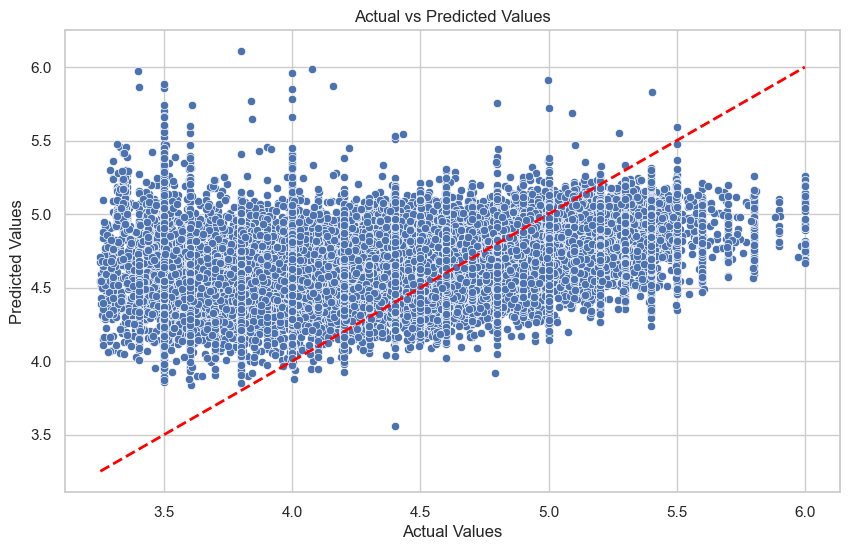

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Vẽ đồ thị so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


### 3.2 Random Forest (Hyperparameter Tuning)

In [15]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_leaf': [10, 20, 50],
    'min_samples_split': [20, 50, 100],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=20,          # Chỉ chạy thử ngẫu nhiên 20 tổ hợp (Tiết kiệm thời gian)
    cv=3,               # Cross-validation 3 lần
    scoring='neg_mean_absolute_error', # Tối ưu hóa dựa trên MAE (Lưu ý: Scikit-learn dùng số âm)
    verbose=2,          # Hiện tiến trình chạy
    random_state=42,
    n_jobs=-1           # Chạy song song đa luồng
)

print("Đang tìm tham số tối ưu (Tuning)...")
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Tính toán các chỉ số
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 30)
print(f"Best Parameters: {random_search.best_params_}")
print("-" * 30)
print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST:")
print(f"R2 Score (Độ phù hợp): {r2:.4f} (Càng gần 1 càng tốt)")
print(f"MSE (Sai số bình phương): {mse:.4f}")
print(f"MAE (Sai số tuyệt đối): {mae:.4f} m/phút") 
print("-" * 30)

# Giải thích MAE cho sếp/đồng nghiệp:
print(f"Diễn giải: Trung bình mô hình gợi ý tốc độ lệch khoảng {mae:.4f} m/phút so với thực tế.")

models_results.append({'Model': 'Random Forest (Tuned)', 'R2': r2, 'MSE': mse, 'MAE': mae})

print(f"Best RF Params: {grid_rf.best_params_}")

Đang tìm tham số tối ưu (Tuning)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


NameError: name 'mean_absolute_error' is not defined

In [19]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 30)
print(f"Best Parameters: {random_search.best_params_}")
print("-" * 30)
print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST:")
print(f"R2 Score (Độ phù hợp): {r2:.4f} (Càng gần 1 càng tốt)")
print(f"MSE (Sai số bình phương): {mse:.4f}")
print(f"MAE (Sai số tuyệt đối): {mae:.4f} m/phút") 
print("-" * 30)

# Giải thích MAE cho sếp/đồng nghiệp:
print(f"Diễn giải: Trung bình mô hình gợi ý tốc độ lệch khoảng {mae:.4f} m/phút so với thực tế.")

models_results.append({'Model': 'Random Forest (Tuned)', 'R2': r2, 'MSE': mse, 'MAE': mae})

------------------------------
Best Parameters: {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20}
------------------------------
KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST:
R2 Score (Độ phù hợp): 0.1698 (Càng gần 1 càng tốt)
MSE (Sai số bình phương): 0.1820
MAE (Sai số tuyệt đối): 0.3253 m/phút
------------------------------
Diễn giải: Trung bình mô hình gợi ý tốc độ lệch khoảng 0.3253 m/phút so với thực tế.


### 3.3 XGBoost (Hyperparameter Tuning)

In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. GỢI Ý BỘ THAM SỐ XGBOOST ---
param_dist_xgb = {
    # Số lượng cây: XGBoost cần nhiều cây hơn nếu Learning Rate thấp
    'n_estimators': [100, 300, 500],
    
    # Tốc độ học (Learning Rate): Quan trọng nhất!
    # 0.01: Học chậm, kỹ, cần nhiều cây (chính xác nhưng lâu).
    # 0.1: Học nhanh vừa phải (Cân bằng).
    # 0.3: Học nhanh, dễ bỏ qua chi tiết (kém chính xác hơn).
    'learning_rate': [0.01, 0.05, 0.1],
    
    # Độ sâu tối đa: XGBoost thường xây cây "nông" hơn Random Forest
    # 6-10 là khoảng đẹp cho dữ liệu công nghiệp.
    'max_depth': [5, 7, 10],
    
    # Tỷ lệ mẫu dùng để train mỗi cây (Subsample)
    # 0.7 nghĩa là: Chỉ lấy ngẫu nhiên 70% dữ liệu để xây 1 cây.
    # -> Cực kỳ quan trọng để CHỐNG NHIỄU SENSOR (giống min_samples_leaf bên RF).
    'subsample': [0.7, 0.8, 0.9],
    
    # Tỷ lệ cột (feature) dùng cho mỗi cây
    # Giúp model không bị phụ thuộc quá mức vào 1 biến (như Nhiệt độ)
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# --- 2. KHỞI TẠO MODEL ---
# n_jobs=1 ở đây để dành CPU cho RandomizedSearchCV điều phối
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    n_jobs=1 
)

# --- 3. CẤU HÌNH RANDOMIZED SEARCH ---
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,                          # Thử ngẫu nhiên 20 tổ hợp
    cv=3,                               # Kiểm tra chéo 3 lần
    scoring='neg_mean_absolute_error',  # Tối ưu theo sai số tuyệt đối (MAE)
    verbose=2,                          # Hiện tiến độ
    random_state=42,
    n_jobs=-1                           # Dùng hết CPU
)

print("Đang tìm tham số tối ưu cho XGBoost (Tuning)...")
# Lưu ý: XGBoost train lâu hơn Random Forest một chút
random_search_xgb.fit(X_train, y_train)

# --- 4. ĐÁNH GIÁ KẾT QUẢ ---
best_xgb = random_search_xgb.best_estimator_

# Dự đoán
y_pred_xgb = best_xgb.predict(X_test)

# Tính toán chỉ số
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb) # MAE quan trọng

# Lưu kết quả vào danh sách tổng hợp để so sánh
models_results.append({
    'Model': 'XGBoost (Randomized Tuned)', 
    'R2': r2_xgb, 
    'MSE': mse_xgb,
    'MAE': mae_xgb
})

print("-" * 30)
print(f"Best XGB Params: {random_search_xgb.best_params_}")
print("-" * 30)
print("KẾT QUẢ XGBOOST:")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"MAE (Sai số tuyệt đối): {mae_xgb:.4f} m/phút")
print("-" * 30)



Đang tìm tham số tối ưu cho XGBoost (Tuning)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
------------------------------
Best XGB Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
------------------------------
KẾT QUẢ XGBOOST:
R2 Score: 0.4330
MAE (Sai số tuyệt đối): 0.2707 m/phút
------------------------------


In [ ]:
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
# grid_xgb.fit(X_train, y_train)

# best_xgb = grid_xgb.best_estimator_
# y_pred_xgb = best_xgb.predict(X_test)

# r2_xgb = r2_score(y_test, y_pred_xgb)
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# models_results.append({'Model': 'XGBoost (Tuned)', 'R2': r2_xgb, 'MSE': mse_xgb})

# print(f"Best XGB Params: {grid_xgb.best_params_}")

## 4. Tổng hợp Kết quả

,Model,R2,MSE
3,Random Forest (Tuned),0.088353,0.207548
4,XGBoost (Tuned),0.084763,0.208366
2,Poly Degree 3,0.080888,0.209248
1,Poly Degree 2,0.080844,0.209258
0,Poly Degree 1,0.071061,0.211485


c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


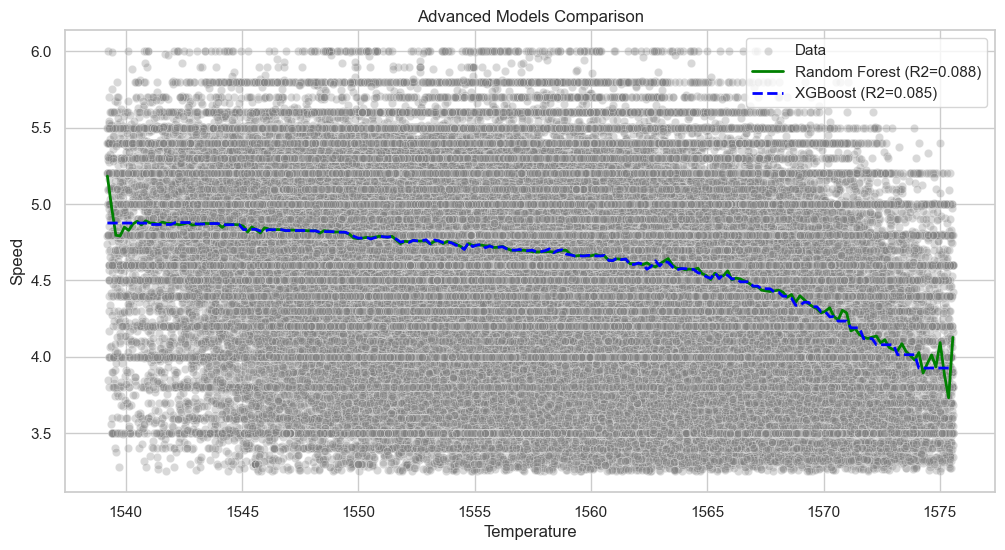

In [ ]:
results_df = pd.DataFrame(models_results).sort_values(by='R2', ascending=False)
display(results_df)

# Visualize Best Models
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperature', y='speed', data=df_final, alpha=0.3, color='gray', label='Data')

X_range = np.linspace(X['temperature'].min(), X['temperature'].max(), 200).reshape(-1, 1)
X_range_df = pd.DataFrame(X_range, columns=['temperature'])

# Plot RF
y_rf_plot = best_rf.predict(X_range_df)
plt.plot(X_range, y_rf_plot, color='green', linewidth=2, label=f'Random Forest (R2={r2_rf:.3f})')

# Plot XGB
y_xgb_plot = best_xgb.predict(X_range_df)
plt.plot(X_range, y_xgb_plot, color='blue', linewidth=2, linestyle='--', label=f'XGBoost (R2={r2_xgb:.3f})')

plt.title('Advanced Models Comparison')
plt.xlabel('Temperature')
plt.ylabel('Speed')
plt.legend()
plt.show()

## 5. Kết luận & Đề xuất

- Quan sát bảng kết quả `R2` và `MSE` để chọn mô hình tốt nhất.
- Nếu **Polynomial** tốt tương đương RF/XGBoost: Nên chọn Polynomial vì đơn giản, dễ giải thích.
- Nếu **RF/XGBoost** vượt trội: Chấp nhận độ phức tạp để đổi lấy độ chính xác. Các mô hình này cũng scale tốt hơn nếu sau này có thêm nhiều features (Độ rộng, Hóa học...).